**This Project aims to Build Small ASR system for Amharic Language**



*   I start By getting a dataset [Contemporary Amharic Corpus (CACO)](http://www.findke.ovgu.de/findke/en/Research/Data+Sets/Contemporary+Amharic+Corpus+%28CACO%29-p-1142.html)
*   I took around 10 splits from the corpus and prepared them to be used with the data collection app



In [ ]:
!pip install torchaudio
!pip install PyDrive
!pip install soundfile

     |████████████████████████████████| 3.2MB 2.6MB/s 


In [ ]:
import os
from random import randint, uniform
import re
import numpy as np
import torch
import wave
import contextlib#
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchaudio
import torch.nn.functional as F

import numpy as np

# **1. Load Data From GitHub (if you have raw unrocessed recordings start from section 2.) if you start here dont run section 2.**

In [ ]:
!git clone https://github.com/IsraelAbebe/Amharic-ASR-Dataset


!cp -r Amharic-ASR-Dataset/* .

Cloning into 'Amharic-ASR-Dataset'...
remote: Enumerating objects: 1177, done.
remote: Counting objects: 100% (1177/1177), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 2098 (delta 1038), reused 1144 (delta 1015), pack-reused 921
Receiving objects: 100% (2098/2098), 210.14 MiB | 15.02 MiB/s, done.
Resolving deltas: 100% (1042/1042), done.
Checking out files: 100% (1010/1010), done.


# **2. Data Processing from raw Recordings (skip to next section (3.) if you dont have the data on drive as a zipped file)**

In [ ]:
%cd /content

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip 'drive/My Drive/data/recordings.zip'


Archive:  drive/My Drive/data/recordings.zip
   creating: recordings/
   creating: recordings/200705-124605_amh_1b9_elicit/
  inflating: recordings/200705-124605_amh_1b9_elicit/200705-124605_amh_1b9_elicit_48-metadata.json  
  inflating: recordings/200705-124605_amh_1b9_elicit/200705-124605_amh_1b9_elicit_1.wav  
  inflating: recordings/200705-124605_amh_1b9_elicit/200705-124605_amh_1b9_elicit_43-metadata.json  
  inflating: recordings/200705-124605_amh_1b9_elicit/200705-124605_amh_1b9_elicit_0-metadata.json  
  inflating: recordings/200705-124605_amh_1b9_elicit/200705-124605_amh_1b9_elicit_85-metadata.json  
  inflating: recordings/200705-124605_amh_1b9_elicit/200705-124605_amh_1b9_elicit_85.wav  
  inflating: recordings/200705-124605_amh_1b9_elicit/200705-124605_amh_1b9_elicit_42.wav  
  inflating: recordings/200705-124605_amh_1b9_elicit/200705-124605_amh_1b9_elicit_15-metadata.json  
  inflating: recordings/200705-124605_amh_1b9_elicit/200705-124605_amh_1b9_elicit_80-metadata.json  

In [ ]:
file_name = "./recordings/"
total,corrupted,files = 0,0,0

for directory in os.listdir(file_name):
    if os.path.isdir(file_name+directory):
        for file in os.listdir(file_name+directory):
            if file.endswith(".wav"):
                files+=1
                fname = file_name+directory+"/"+file
                try:
                    with contextlib.closing(wave.open(fname,'r')) as f:
                        frames = f.getnframes()
                        rate = f.getframerate()
                        duration = frames / float(rate)
                        total+=duration
                except Exception as e:
                    corrupted+=1

print("Total recording time {} hours with {} files".format(total/(60*60),files))

Total recording time 2.297455989583336 hours with 1006 files


In [ ]:
folder_name = "./recordings/"
!mkdir data
!mkdir data/records

# Extracting all the non-corrupted files
wav_files = []
linker = []
for directory in os.listdir(folder_name): # parent directory of the recordings, it should contain folders that contain wav,json and txt files
    if os.path.isdir(folder_name+directory):
        to_remove = []
        for file in os.listdir(folder_name+directory):
            if file.endswith(".txt"):
                linker_data = open(folder_name+directory+"/"+file).readlines()
            if file.endswith(".wav"):
                fname = folder_name+directory+"/"+file
                try:
                    with contextlib.closing(wave.open(fname,'r')) as f:
                        frames = f.getnframes()
                        rate = f.getframerate()
                        duration = frames / float(rate)
                        wav_files.append(fname)
                except Exception as e:
                    to_remove.append(file)
        for file in to_remove:
            i=0
            while i<len(linker_data):
                if file in linker_data[i]:
                    linker_data.pop(i)
                i+=1
        linker.extend(linker_data)



to_copy = " ".join(wav_files)
!cp -t data/records/ {to_copy}

for i,link in enumerate(linker):
    line = link.split(";")[0].split("(")[1].split(")")[0].strip()
    wav = link.split(";")[1].strip().split("/")[-1]
    linker[i] = wav+":"+line


out_linker = open(".linker.txt","w")
out_linker.write("\n".join(linker))
out_linker.close()

!mkdir ./data/records/train
!mkdir ./data/records/test
!mkdir ./data/records/val


np.random.seed(0)
indices = np.random.permutation(len(wav_files))

test_idx = indices[:len(indices)//2]
validation_portion = int(len(indices)//2 * 0.2)
train_idx = indices[len(indices)//2:-validation_portion]
valid_idx = indices[-validation_portion:]

train_set_files = [wav_files[i].split("/")[-1] for i in train_idx]
valid_set_files = [wav_files[i].split("/")[-1] for i in valid_idx]
test_set_files = [wav_files[i].split("/")[-1] for i in test_idx]

to_copy_train = "./data/records/" + " ./data/records/".join(train_set_files)
to_copy_valid = "./data/records/" + " ./data/records/".join(valid_set_files)
to_copy_test = "./data/records/" + " ./data/records/".join(test_set_files)

!mv -t data/records/train/ {to_copy_train}
!mv -t data/records/val/ {to_copy_valid}
!mv -t data/records/test/ {to_copy_test}

### Text Preprocessing



*   Replacing simmilar sounding letters
*   Removing unessesery smbols



In [ ]:
simmilar_characters = {"ሐ":"ሀ","ሑ":"ሁ","ሒ":"ሂ","ሓ":"ሃ","ሔ":"ሄ","ሕ":"ህ","ሖ":"ሆ",\
                       "ኀ":"ሀ","ኁ":"ሁ","ኂ":"ሂ","ኃ":"ሃ","ኄ":"ሄ","ኅ":"ህ","ኆ":"ሆ",\
                       "ሠ":"ሰ","ሡ":"ሱ","ሢ":"ሲ","ሣ":"ሳ","ሤ":"ሴ","ሥ":"ስ","ሦ":"ሶ","ሧ":"ሷ",\
                       "ዐ":"አ","ዑ":"ኡ","ዒ":"ኢ","ዓ":"ኣ","ዔ":"ኤ","ዕ":"እ","ዖ":"ኦ",\
                       "ጸ":"ፀ","ጹ":"ፁ","ጺ":"ፂ","ጻ":"ፃ","ጼ":"ፄ","ጽ":"ፅ","ጾ":"ፆ"}

	


def preprocess(text,replace_characters=True,replace_punctuation=True,remove_last=0):
    text = text.lower()
    if replace_punctuation:
        text = text.replace('.', '')
        text = text.replace(',', '')
        text = text.replace('"', '')
        text = text.replace(';', '')
        text = text.replace('!', '')
        text = text.replace('?', '')
        text = text.replace('(', '')
        text = text.replace(')', '')
        text = text.replace('--', '')
        text = text.replace('?', '')
        text = text.replace('።', '')
        text = text.replace('፣', '')
        # text = text.replace('\n', ' <NEW_LINE> ')
        text = text.replace(':', '')
        text = text.replace('፤','')
        text = text.replace('…','')
        text = text.replace('[','')
        text = text.replace(']','')
        
    if replace_characters:
        for letter, alternative in simmilar_characters.items():
            text = text.replace(letter, alternative)
    
    return text

import re
text_file = open("recordings/amharic.txt","r").readlines() # Modify this to the directory of your txt file that you recorded with
text_data = []
chars = {" ":1,"ε":0}
char_idx = 2
for link in linker:
    file,idx = link.split(":")[0],int(link.split(":")[1].split(" ")[1])-1
    line = text_file[idx]
    line = preprocess(line)
    text_data.append((line,file.split(".")[0]))
    char_set = set(line)
    for c in char_set:
        if c not in chars:
            chars[c]=char_idx
            char_idx+=1

In [ ]:
raw_text = "\n".join([wav+":"+line for line,wav in text_data])
with open("raw_text_file.txt","w") as f:
    f.write(raw_text)


indices_text = []
for line,wav in text_data:
    line = list(line)
    indicies = []
    for c in line:
        indicies.append(str(chars[c]))
    indices_text.append(wav+" "+" ".join(indicies))


indicies_text = "\n".join(indices_text)
with open("chars.txt","w") as f:
    f.write(indicies_text)

with open("charset.json","w") as js:
    js.write(str(chars))

with open("charset.json") as js:
    charset = eval(js.read())

In [ ]:
!zip -r data.zip data/

  adding: data/ (stored 0%)
  adding: data/records/ (stored 0%)
  adding: data/records/test/ (stored 0%)
  adding: data/records/test/100101-204215_amh_57b_elicit_19.wav (deflated 10%)
  adding: data/records/test/100103-032808_amh_57b_elicit_30.wav (deflated 23%)
  adding: data/records/test/100102-082603_amh_57b_elicit_8.wav (deflated 11%)
  adding: data/records/test/100103-032808_amh_57b_elicit_36.wav (deflated 23%)
  adding: data/records/test/100102-082603_amh_57b_elicit_23.wav (deflated 12%)
  adding: data/records/test/100101-050203_amh_57b_elicit_43.wav (deflated 23%)
  adding: data/records/test/100102-214735_amh_57b_elicit_36.wav (deflated 30%)
  adding: data/records/test/100102-021202_amh_57b_elicit_5.wav (deflated 15%)
  adding: data/records/test/100102-214735_amh_57b_elicit_1.wav (deflated 20%)
  adding: data/records/test/100101-050203_amh_57b_elicit_57.wav (deflated 23%)
  adding: data/records/test/100101-050203_amh_57b_elicit_2.wav (deflated 26%)
  adding: data/records/test/10

#  **3. CPC Model**

In [ ]:
!git clone https://github.com/facebookresearch/CPC_audio.git

Cloning into 'CPC_audio'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 84 (delta 13), reused 75 (delta 6), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [ ]:
%cd /content/CPC_audio
!python setup.py develop

/content/CPC_audio
Compiling cpc/eval/ABX/dtw.pyx because it changed.
[1/1] Cythonizing cpc/eval/ABX/dtw.pyx
running develop
running egg_info
creating CPC_audio.egg-info
writing CPC_audio.egg-info/PKG-INFO
writing dependency_links to CPC_audio.egg-info/dependency_links.txt
writing top-level names to CPC_audio.egg-info/top_level.txt
writing manifest file 'CPC_audio.egg-info/SOURCES.txt'
writing manifest file 'CPC_audio.egg-info/SOURCES.txt'
running build_ext
building 'cpc.eval.ABX.dtw' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/cpc
creating build/temp.linux-x86_64-3.6/cpc/eval
creating build/temp.linux-x86_64-3.6/cpc/eval/ABX
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I/usr/include/python3.6m -c cpc/eval/ABX/dtw.c -o build/temp.linux-x86_64-3.6/cpc/eval/ABX/

In [ ]:
%cd /content/CPC_audio
from cpc.model import CPCEncoder, CPCAR

DIM_ENCODER=128
DIM_CONTEXT=128
KEEP_HIDDEN_VECTOR=False
N_LEVELS_CONTEXT=1
CONTEXT_RNN="LSTM"
N_PREDICTIONS=12
LEARNING_RATE=2e-4
N_NEGATIVE_SAMPLE =128


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/content/CPC_audio


In [ ]:
encoder = CPCEncoder(DIM_ENCODER)
context = CPCAR(DIM_ENCODER, DIM_CONTEXT, KEEP_HIDDEN_VECTOR, 1, mode=CONTEXT_RNN)

In [ ]:
# Several functions that will be necessary to load the data later
from cpc.dataset import findAllSeqs, AudioBatchData, parseSeqLabels
SIZE_WINDOW = 20480
BATCH_SIZE=8
def load_dataset(path_dataset, file_extension='.wav', phone_label_dict=None):
  data_list, speakers = findAllSeqs(path_dataset, extension=file_extension)
  dataset = AudioBatchData(path_dataset, SIZE_WINDOW, data_list, phone_label_dict, len(speakers))
  return dataset

In [ ]:
class CPCModel(torch.nn.Module):
    def __init__(self,
                 encoder,
                 AR):
        super(CPCModel, self).__init__()
        self.gEncoder = encoder
        self.gAR = AR

    def forward(self, batch_data):
        encoder_output = self.gEncoder(batch_data)
        context_input = encoder_output.permute(0, 2, 1)
        context_output = self.gAR(context_input)
        return context_output, encoder_output

In [ ]:
audio = torchaudio.load("../data/records/train/100101-050203_amh_57b_elicit_0.wav")[0]
audio = audio.view(1, 1, -1)
cpc_model = CPCModel(encoder, context)
context_output, encoder_output = cpc_model(audio)

print(context_output.shape,encoder_output.shape)

torch.Size([1, 249, 128]) torch.Size([1, 128, 249])


In [ ]:
class CPCCriterion(torch.nn.Module):
  def __init__(self,
               K,
               dim_context,
               dim_encoder,
               n_negative):
    super(CPCCriterion, self).__init__()
    self.K_ = K
    self.dim_context = dim_context
    self.dim_encoder = dim_encoder
    self.n_negative = n_negative
    self.predictors = torch.nn.ModuleList() 
    for k in range(self.K_):
      self.predictors.append(torch.nn.Linear(dim_context, dim_encoder, bias=False))

  def get_prediction_k(self, context_data):
    output = [] 
    for k in range(self.K_):
      # We need to compute phi_k = A_k * c_t
      phi_k = self.predictors[k](context_data)
      output.append(phi_k)

    return output


  def sample_negatives(self, encoded_data):
    r"""
    Sample some negative examples in the given encoded data.
    Input:
    - encoded_data size: B x T x H
    Returns
    - outputs of size B x (n_negative + 1) x (T - K_) x H
      outputs[:, 0, :, :] contains the positive example
      outputs[:, 1:, :, :] contains negative example sampled in the batch
    - labels, long tensor of size B x (T - K_)
      Since the positive example is always at coordinates 0 for all sequences 
      in the batch and all timestep in the sequence, labels is just a tensor
      full of zeros !
    """
    batch_size, time_size, dim_encoded = encoded_data.size()
    window_size = time_size - self.K_
    outputs = []

    neg_ext = encoded_data.contiguous().view(-1, dim_encoded)
    n_elem_sampled = self.n_negative * window_size * batch_size
    # Draw nNegativeExt * batchSize negative samples anywhere in the batch
    batch_idx = torch.randint(low=0, high=batch_size,
                              size=(n_elem_sampled, ),
                              device=encoded_data.device)

    seq_idx = torch.randint(low=1, high=time_size,
                            size=(n_elem_sampled, ),
                            device=encoded_data.device)

    base_idx = torch.arange(0, window_size, device=encoded_data.device)
    base_idx = base_idx.view(1, 1, window_size)
    base_idx = base_idx.expand(1, self.n_negative, window_size)
    base_idx = base_idx.expand(batch_size, self.n_negative, window_size)
    seq_idx += base_idx.contiguous().view(-1)
    seq_idx = torch.remainder(seq_idx, time_size)

    ext_idx = seq_idx + batch_idx * time_size
    neg_ext = neg_ext[ext_idx].view(batch_size, self.n_negative,
                                    window_size, dim_encoded)

    label_loss = torch.zeros((batch_size, window_size),
                              dtype=torch.long,
                              device=encoded_data.device)

    for k in range(1, self.K_ + 1):

      # Positive samples
      if k < self.K_:
          pos_seq = encoded_data[:, k:-(self.K_-k)]
      else:
          pos_seq = encoded_data[:, k:]

      pos_seq = pos_seq.view(batch_size, 1, pos_seq.size(1), dim_encoded)
      full_seq = torch.cat((pos_seq, neg_ext), dim=1)
      outputs.append(full_seq)

    return outputs, label_loss

  def forward(self, encoded_data, context_data):

    # TO COMPLETE:
    # Perform the full cpc criterion
    # Returns 2 values:
    # - the average classification loss avg_loss
    # - the average classification acuracy avg_acc

    # Reminder : The permuation !
    encoded_data = encoded_data.permute(0, 2, 1)

    # First we need to sample the negative examples
    negative_samples, labels = self.sample_negatives(encoded_data)

    # Then we must compute phi_k
    phi_k = self.get_prediction_k(context_data)

    # Finally we must get the dot product between phi_k and negative_samples 
    # for each k

    #The total loss is the average of all losses
    avg_loss = 0

    # Average acuracy
    avg_acc = 0

    for k in range(self.K_):
      B, N_sampled, S_small, H = negative_samples[k].size() 
      B, S, H = phi_k[k].size()

      # As told before S = S_small + K. For segments too far in the sequence
      # there are no positive exmples anyway, so we must shorten phi_k
      phi = phi_k[k][:, :S_small]

      # Now the dot product
      # You have several ways to do that, let's do the simple but non optimal 
      # one
      # pytorch has a matrix product function https://pytorch.org/docs/stable/torch.html#torch.bmm
      # But it takes only 3D tensors of the same batch size !
      # To begin negative_samples is a 4D tensor ! 
      # We want to compute the dot product for each features, of each sequence
      # of the batch. Thus we are trying to compute a dot product for all
      # B* N_sampled * S_small 1D vector of negative_samples[k]
      # Or, a 1D tensor of size H is also a matrix of size 1 x H
      # Then, we must view it as a 3D tensor of size (B* N_sampled * S_small, 1, H)
      negative_sample_k  =  negative_samples[k].view(B* N_sampled* S_small, 1, H)

      # But now phi and negative_sample_k no longer have the same batch size !
      # No worries, we can expand phi so that each sequence of the batch
      # is repeated N_sampled times
      phi = phi.view(B, 1,S_small, H).expand(B, N_sampled, S_small, H)

      # And now we can view it as a 3D tensor 
      phi  = phi.contiguous().view(B * N_sampled * S_small, H, 1)

      # We can finally get the dot product !
      scores = torch.bmm(negative_sample_k, phi)

      # Dot_product has a size (B * N_sampled * S_small , 1, 1)
      # Let's reorder it a bit
      scores = scores.view(B, N_sampled, S_small)

      # For each elements of the sequence, and each elements sampled, it gives 
      # a floating score stating the likelihood of this element being the 
      # true one.
      # Now the classification loss, we need to use the Cross Entropy loss
      # https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html

      # For each time-step of each sequence of the batch 
      # we have N_sampled possible predictions. 
      # Looking at the documentation of torch.nn.CrossEntropyLoss
      # we can see that this loss expect a tensor of size M x C where 
      # - M is the number of elements with a classification score
      # - C is the number of possible classes
      # There are N_sampled candidates for each predictions so
      # C = N_sampled 
      # Each timestep of each sequence of the batch has a prediction so
      # M = B * S_small
      # Thus we need an input vector of size B * S_small, N_sampled
      # To begin, we need to permute the axis
      scores = scores.permute(0, 2, 1) # Now it has size B , S_small, N_sampled

      # Then we can cast it into a 2D tensor
      scores = scores.reshape(B * S_small, N_sampled)

      # Same thing for the labels 
      labels = labels.view(B * S_small)

      # Finally we can get the classification loss
      loss_criterion = torch.nn.CrossEntropyLoss()
      loss_k = loss_criterion(scores, labels)
      avg_loss+= loss_k

      # And for the acuracy
      # The prediction for each elements is the sample with the highest score
      # Thus the tensors of all predictions is the tensors of the index of the 
      # maximal score for each time-step of each sequence of the batch
      predictions = torch.argmax(scores, 1)
      acc_k  = (labels == predictions) / (B * S_small)
      avg_acc += acc_k

    # Normalization
    avg_loss = avg_loss / self.K_
    avg_acc = avg_acc / self.K_
      
    return avg_loss , avg_acc

In [ ]:
audio = torchaudio.load("../data/records/train/100101-050203_amh_57b_elicit_0.wav")[0]
audio = audio.view(1, 1, -1)
cpc_criterion = CPCCriterion(N_PREDICTIONS, DIM_ENCODER, 
                             DIM_CONTEXT, N_NEGATIVE_SAMPLE)
context_output, encoder_output = cpc_model(audio)
loss, avg = cpc_criterion(encoder_output,context_output)

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [ ]:
parameters = list(cpc_criterion.parameters()) + list(cpc_model.parameters())
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)

In [ ]:
dataset_train = load_dataset('../data/records/train/')
dataset_val = load_dataset('../data/records/val/')

1it [00:00, 270.11it/s]

Saved cache file at ../data/records/train/_seqs_cache.txt



402it [00:00, 375442.04it/s]

Checking length...
Done, elapsed: 0.073 seconds
Scanned 402 sequences in 0.07 seconds
1 chunks computed
Joining pool


Joined process, elapsed=1.109 secs


1it [00:00, 224.35it/s]

Saved cache file at ../data/records/val/_seqs_cache.txt



100it [00:00, 37854.73it/s]

Checking length...
Done, elapsed: 0.034 seconds
Scanned 100 sequences in 0.03 seconds
1 chunks computed
Joining pool


Joined process, elapsed=0.488 secs


In [ ]:

data_loader_train = dataset_train.getDataLoader(BATCH_SIZE, "speaker", True)
data_loader_val = dataset_train.getDataLoader(BATCH_SIZE, "sequence", False)

In [ ]:
def train_step(data_loader,
               cpc_model,
               cpc_criterion,
               optimizer):
  
  avg_loss = 0
  avg_acc = 0
  n_items = 0

  for step, data in enumerate(data_loader):
    x,y = data
    x,y = x.cuda(),y.cuda()
    bs = len(x)
    optimizer.zero_grad()
    context_output, encoder_output = cpc_model(x)
    loss , acc = cpc_criterion(encoder_output, context_output)
    loss.backward()
    n_items+=bs
    avg_loss+=loss.item()*bs
    avg_acc +=acc.sum()*bs
  
  avg_loss/=n_items
  avg_acc/=n_items
  return avg_loss, avg_acc

In [ ]:
def validation_step(data_loader,
                    cpc_model,
                    cpc_criterion):
  
  avg_loss = 0
  avg_acc = 0
  n_items = 0

  for step, data in enumerate(data_loader):
    x,y = data
    x,y = x.cuda(),y.cuda()
    bs = len(x)
    context_output, encoder_output = cpc_model(x)
    loss , acc = cpc_criterion(encoder_output, context_output)
    n_items+=bs
    avg_loss+=loss.item()*bs
    avg_acc+=acc.sum()*bs
  
  avg_loss/=n_items
  avg_acc/=n_items
  return avg_loss, avg_acc

In [ ]:
def run(train_loader,
        val_loader,
        cpc_model,
        cpc_criterion,
        optimizer,
        n_epochs):
  
  for epoch in range(n_epochs):

    
    print(f"Running epoch {epoch+1} / {n_epochs}")
    avg_loss_train, avg_acc_train = train_step(train_loader, cpc_model, cpc_criterion, optimizer)
    print("----------------------")
    print(f"Training dataset")
    print(f"- average loss : {avg_loss_train}")
    print(f"- average acuracy : {avg_acc_train}")
    print("----------------------")

    avg_loss_val, avg_acc_val = validation_step(val_loader, cpc_model, cpc_criterion)
    print(f"Validation dataset")
    print(f"- average loss : {avg_loss_train}")
    print(f"- average acuracy : {avg_acc_train}")
    print("----------------------")
    print()

    break

run(data_loader_val,
        data_loader_val,
        cpc_model.cuda(),
        cpc_criterion.cuda(),
        optimizer,
        2)

Running epoch 1 / 2


/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


----------------------
Training dataset
- average loss : 4.869873329231746
- average acuracy : 0
----------------------
Validation dataset
- average loss : 4.869873329231746
- average acuracy : 0
----------------------



# **4. Fine tuning**

In [ ]:
!mkdir checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt -P checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json -P checkpoint_data
!wget https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_args.json -P checkpoint_data
!ls checkpoint_data

--2020-07-06 12:44:39--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_30.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113599715 (108M) [application/octet-stream]
Saving to: ‘checkpoint_data/checkpoint_30.pt’

checkpoint_30.pt    100%[===================>] 108.34M  12.0MB/s    in 10s     

2020-07-06 12:44:50 (10.5 MB/s) - ‘checkpoint_data/checkpoint_30.pt’ saved [113599715/113599715]

--2020-07-06 12:44:52--  https://dl.fbaipublicfiles.com/librilight/CPC_checkpoints/not_hub/2levels_6k_top_ctc/checkpoint_logs.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, 

In [ ]:
%cd /content/CPC_audio
from cpc.dataset import parseSeqLabels
from cpc.feature_loader import loadModel

checkpoint_path = 'checkpoint_data/checkpoint_30.pt'
cpc_model, HIDDEN_CONTEXT_MODEL, HIDDEN_ENCODER_MODEL = loadModel([checkpoint_path])
cpc_model = cpc_model.cuda()
label_dict, N_PHONES = parseSeqLabels('../chars.txt')
dataset_train = load_dataset('../data/records/train/', file_extension='.wav', phone_label_dict=label_dict)
dataset_val = load_dataset('../data/records/val/', file_extension='.wav', phone_label_dict=label_dict)
data_loader_train = dataset_train.getDataLoader(BATCH_SIZE, "speaker", True)
data_loader_val = dataset_val.getDataLoader(BATCH_SIZE, "sequence", False)

1it [00:00, 252.38it/s]

/content/CPC_audio
Loading checkpoint checkpoint_data/checkpoint_30.pt
Loading the state dict at checkpoint_data/checkpoint_30.pt
Saved cache file at ../data/records/train/_seqs_cache.txt



402it [00:00, 181224.23it/s]

Checking length...
Done, elapsed: 0.065 seconds
Scanned 402 sequences in 0.06 seconds
1 chunks computed
Joining pool


Joined process, elapsed=1.095 secs


1it [00:00, 34.45it/s]

Saved cache file at ../data/records/val/_seqs_cache.txt



100it [00:00, 41429.32it/s]

Checking length...
Done, elapsed: 0.046 seconds
Scanned 100 sequences in 0.05 seconds
1 chunks computed
Joining pool


Joined process, elapsed=0.471 secs


In [ ]:
class PhoneClassifier(torch.nn.Module):
    def __init__(self,
                input_dim : int,
                n_phones : int):
        super(PhoneClassifier, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, 1024)
        self.linear2 = torch.nn.Linear(1024, 512)
        self.linear3 = torch.nn.Linear(512, n_phones)


    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [ ]:
phone_classifier = PhoneClassifier(HIDDEN_CONTEXT_MODEL, N_PHONES).cuda()

loss_criterion = torch.nn.CrossEntropyLoss()
parameters = list(phone_classifier.parameters()) + list(cpc_model.parameters())
LEARNING_RATE = 2e-4
optimizer_frozen = torch.optim.Adam(list(phone_classifier.parameters()), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)

optimizer_frozen = torch.optim.Adam(list(phone_classifier.parameters()), lr=LEARNING_RATE)

In [ ]:
def train_one_epoch(cpc_model, 
                    phone_classifier, 
                    loss_criterion, 
                    data_loader, 
                    optimizer):

  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):
    # Each batch is represented by a Tuple of vectors:
    # sequence of size : N x 1 x T
    # label of size : N x T
    # 
    # With :
    # - N number of sequence in the batch
    # - T size of each sequence
    sequence, label = full_data
    
    

    bs = len(sequence)
    seq_len = label.size(1)
    optimizer.zero_grad()
    context_out, enc_out, _ = cpc_model(sequence.to(device),label.to(device))

    scores = phone_classifier(context_out)

    scores = scores.permute(0,2,1)
    loss = loss_criterion(scores,label.to(device))
    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
    correct_labels = scores.argmax(1)
    avg_accuracy += ((label==correct_labels.cpu()).float()).mean(1).sum().item()
  avg_loss/=n_items
  avg_accuracy/=n_items
  return avg_loss, avg_accuracy
    

In [ ]:
def validation_step(cpc_model, 
                    phone_classifier, 
                    loss_criterion, 
                    data_loader):
  
  cpc_model.eval()
  phone_classifier.eval()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):
      # Each batch is represented by a Tuple of vectors:
      # sequence of size : N x 1 x T
      # label of size : N x T
      # 
      # With :
      # - N number of sequence in the batch
      # - T size of each sequence
      sequence, label = full_data
      bs = len(sequence)
      seq_len = label.size(1)
      context_out, enc_out, _ = cpc_model(sequence.to(device),label.to(device))
      scores = phone_classifier(context_out)
      scores = scores.permute(0,2,1)
      loss = loss_criterion(scores,label.to(device))
      avg_loss+=loss.item()*bs
      n_items+=bs
      correct_labels = scores.argmax(1)
      avg_accuracy += ((label==correct_labels.cpu()).float()).mean(1).sum().item()
  avg_loss/=n_items
  avg_accuracy/=n_items
  return avg_loss, avg_accuracy

In [ ]:
def run(cpc_model, 
        phone_classifier, 
        loss_criterion, 
        data_loader_train, 
        data_loader_val, 
        optimizer,
        n_epoch):

    train_cpc_loss = []
    train_cpc_acc = []
    val_cpc_loss = []
    val_cpc_acc = []

    for epoch in range(n_epoch):
        loss_train, acc_train = train_one_epoch(cpc_model, phone_classifier, loss_criterion, data_loader_train, optimizer)
        train_cpc_loss.append(loss_train)
        train_cpc_acc.append(acc_train)

        loss_val, acc_val = validation_step(cpc_model, phone_classifier, loss_criterion, data_loader_val)
        val_cpc_loss.append(loss_val)
        val_cpc_acc.append(acc_val)

        print(f"Running epoch {epoch + 1} / {n_epoch}")
        print("-------------------")
        print(f"Training dataset :")
        print(f"Average loss : {loss_train}. Average accuracy {acc_train}")

        print("-------------------")
        print("Validation dataset")
        print(f"Average loss : {loss_val}. Average accuracy {acc_val}")
        print("-------------------")
        print()

    return train_cpc_loss,train_cpc_acc ,val_cpc_loss ,val_cpc_acc 

In [ ]:
train_cpc_loss,train_cpc_acc ,val_cpc_loss ,val_cpc_acc  = run(cpc_model,phone_classifier,loss_criterion,data_loader_train,data_loader_val,optimizer_frozen,n_epoch=10)

Running epoch 1 / 10
-------------------
Training dataset :
Average loss : 4.832525924400047. Average accuracy 0.22280092592592593
-------------------
Validation dataset
Average loss : 4.098406195640564. Average accuracy 0.24446614583333334
-------------------

Running epoch 2 / 10
-------------------
Training dataset :
Average loss : 4.006521595848931. Average accuracy 0.23842592592592593
-------------------
Validation dataset
Average loss : 3.9287178119023642. Average accuracy 0.24625651041666666
-------------------

Running epoch 3 / 10
-------------------
Training dataset :
Average loss : 3.9304127163357205. Average accuracy 0.2384982638888889
-------------------
Validation dataset
Average loss : 3.923597534497579. Average accuracy 0.24641927083333334
-------------------

Running epoch 4 / 10
-------------------
Training dataset :
Average loss : 3.9180754908808955. Average accuracy 0.23933015046296297
-------------------
Validation dataset
Average loss : 3.8916033109029136. Average

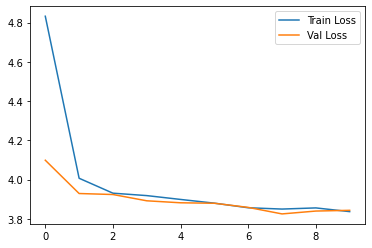

In [ ]:
df = pd.concat([pd.DataFrame(train_cpc_loss),pd.DataFrame(val_cpc_loss)],axis=1)
df.columns = ['Train Loss','Val Loss']
df.plot()

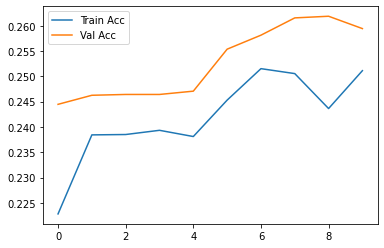

In [ ]:

df = pd.concat([pd.DataFrame(train_cpc_acc),pd.DataFrame(val_cpc_acc)],axis=1)
df.columns = ['Train Acc','Val Acc']
df.plot()

## **CTC loss Training**

In [ ]:
loss_ctc = torch.nn.CTCLoss()

In [ ]:

%cd /content/CPC_audio
from cpc.eval.common_voices_eval import SingleSequenceDataset, parseSeqLabels, findAllSeqs
path_train_data_per = '../data/records/train/'
path_val_data_per = '../data/records/val/'
path_test_data_per = '../data/records/test/'
BATCH_SIZE=8

phone_labels, N_PHONES = parseSeqLabels('../chars.txt')
data_train_per, _ = findAllSeqs(path_train_data_per, extension='.wav')
dataset_train_non_aligned = SingleSequenceDataset(path_train_data_per, data_train_per, phone_labels)
data_loader_train = torch.utils.data.DataLoader(dataset_train_non_aligned, batch_size=BATCH_SIZE,
                                                shuffle=True)

data_val_per, _ = findAllSeqs(path_val_data_per, extension='.wav')
dataset_val_non_aligned = SingleSequenceDataset(path_val_data_per, data_val_per, phone_labels)
data_loader_val = torch.utils.data.DataLoader(dataset_val_non_aligned, batch_size=BATCH_SIZE,
                                              shuffle=True)

data_test_per, _ = findAllSeqs(path_test_data_per, extension='.wav')
dataset_test_non_aligned = SingleSequenceDataset(path_test_data_per, data_test_per, phone_labels)
data_loader_test = torch.utils.data.DataLoader(dataset_test_non_aligned, batch_size=BATCH_SIZE,
                                              shuffle=True)

1it [00:00, 298.70it/s]

/content/CPC_audio
Saved cache file at ../data/records/train/_seqs_cache.txt



1it [00:00, 540.92it/s]

Loaded 403 sequences in 3.09 seconds
maxSizeSeq : 579711
maxSizePhone : 231
minSizePhone : 11
Total size dataset 0.9424454340277778 hours
Saved cache file at ../data/records/val/_seqs_cache.txt



1it [00:00, 200.15it/s]

Loaded 101 sequences in 2.13 seconds
maxSizeSeq : 346302
maxSizePhone : 194
minSizePhone : 15
Total size dataset 0.23266661458333332 hours
Saved cache file at ../data/records/test/_seqs_cache.txt


Loaded 503 sequences in 3.16 seconds
maxSizeSeq : 673728
maxSizePhone : 273
minSizePhone : 11
Total size dataset 1.1223261805555556 hours


In [ ]:
from cpc.feature_loader import loadModel

checkpoint_path = 'checkpoint_data/checkpoint_30.pt'
cpc_model, HIDDEN_CONTEXT_MODEL, HIDDEN_ENCODER_MODEL = loadModel([checkpoint_path])
cpc_model = cpc_model.cuda()
phone_classifier = PhoneClassifier(HIDDEN_CONTEXT_MODEL, N_PHONES).to(device)

Loading checkpoint checkpoint_data/checkpoint_30.pt
Loading the state dict at checkpoint_data/checkpoint_30.pt


In [ ]:
parameters = list(phone_classifier.parameters()) + list(cpc_model.parameters())
LEARNING_RATE = 2e-4
optimizer = torch.optim.Adam(parameters, lr=LEARNING_RATE)

optimizer_frozen = torch.optim.Adam(list(phone_classifier.parameters()), lr=LEARNING_RATE)

In [ ]:
import torch.nn.functional as F

def train_one_epoch_ctc(cpc_model, 
                        phone_classifier, 
                        loss_criterion, 
                        data_loader, 
                        optimizer):
  
  cpc_model.train()
  loss_criterion.train()

  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  for step, full_data in enumerate(data_loader):

    x, x_len, y, y_len = full_data

    x_batch_len = x.shape[-1]
    x, y = x.to(device), y.to(device)

    bs=x.size(0)
    optimizer.zero_grad()
    context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
  
    scores = phone_classifier(context_out)
    scores = scores.permute(1,0,2)
    scores = F.log_softmax(scores,2)
    yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

    loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
    loss.backward()
    optimizer.step()
    avg_loss+=loss.item()*bs
    n_items+=bs
  avg_loss/=n_items
  return avg_loss

def validation_step(cpc_model, 
                    phone_classifier, 
                    loss_criterion, 
                    data_loader):

  cpc_model.eval()
  phone_classifier.eval()
  avg_loss = 0
  avg_accuracy = 0
  n_items = 0
  with torch.no_grad():
    for step, full_data in enumerate(data_loader):

      x, x_len, y, y_len = full_data

      x_batch_len = x.shape[-1]
      x, y = x.to(device), y.to(device)

      bs=x.size(0)
      context_out, enc_out, _ = cpc_model(x.to(device),y.to(device))
    
      scores = phone_classifier(context_out)
      scores = scores.permute(1,0,2)
      scores = F.log_softmax(scores,2)
      yhat_len = torch.tensor([int(scores.shape[0]*x_len[i]/x_batch_len) for i in range(scores.shape[1])]) # this is an approximation, should be good enough

      loss = loss_criterion(scores,y.to(device),yhat_len,y_len)
      avg_loss+=loss.item()*bs
      n_items+=bs
  avg_loss/=n_items

  return avg_loss

def run_ctc(cpc_model, 
            phone_classifier, 
            loss_criterion, 
            data_loader_train, 
            data_loader_val, 
            optimizer,
            n_epoch):
    
    train_loss = []
    val_loss = []
    for epoch in range(n_epoch):

        
        loss_train = train_one_epoch_ctc(cpc_model, phone_classifier, loss_criterion, data_loader_train, optimizer)
        train_loss.append(loss_train)
        
        loss_val = validation_step(cpc_model, phone_classifier, loss_criterion, data_loader_val)
        val_loss.append(loss_val)

        if epoch% 10 == 0:
            print(f"Running epoch {epoch + 1} / {n_epoch}")
            print("-------------------")
            print(f"Training dataset :")
            print(f"Average loss : {loss_train}.")

            print("-------------------")
            print("Validation dataset")

            print(f"Average loss : {loss_val}")
            print("-------------------")
            print()
    return  train_loss ,val_loss

In [ ]:
train_loss ,val_loss = run_ctc(cpc_model,phone_classifier,loss_ctc,data_loader_train,data_loader_val,optimizer_frozen,n_epoch=50)

Running epoch 1 / 50
-------------------
Training dataset :
Average loss : 32.190491173397845.
-------------------
Validation dataset
Average loss : 5.813808784484864
-------------------

Running epoch 11 / 50
-------------------
Training dataset :
Average loss : 4.226558801546619.
-------------------
Validation dataset
Average loss : 4.19194637298584
-------------------

Running epoch 21 / 50
-------------------
Training dataset :
Average loss : 4.102294452154815.
-------------------
Validation dataset
Average loss : 4.083741750717163
-------------------

Running epoch 31 / 50
-------------------
Training dataset :
Average loss : 4.028665051531436.
-------------------
Validation dataset
Average loss : 4.080303077697754
-------------------

Running epoch 41 / 50
-------------------
Training dataset :
Average loss : 4.003568472553842.
-------------------
Validation dataset
Average loss : 3.979283905029297
-------------------



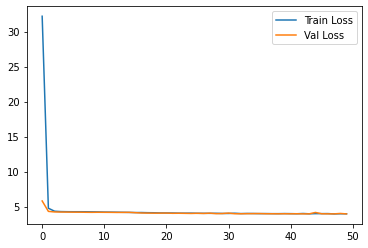

In [ ]:

df = pd.concat([pd.DataFrame(train_loss),pd.DataFrame(val_loss)],axis=1)
df.columns = ['Train Loss','Val Loss']
df.plot()

In [ ]:
import progressbar
from multiprocessing import Pool

import numpy as np

def get_PER_sequence(ref_seq, target_seq):

  # re = g.split()
  # h = h.split()
  n = len(ref_seq)
  m = len(target_seq)

  D = np.zeros((n+1,m+1))
  for i in range(1,n+1):
    D[i,0] = D[i-1,0]+1
  for j in range(1,m+1):
    D[0,j] = D[0,j-1]+1

  for i in range(1,n+1):
    for j in range(1,m+1):
      D[i,j] = min(
          D[i-1,j]+1,
          D[i-1,j-1]+1,
          D[i,j-1]+1,
          D[i-1,j-1]+ 0 if ref_seq[i-1]==target_seq[j-1] else float("inf")
      )
  return D[n,m]/len(ref_seq)
  

def cut_data(seq, sizeSeq):
    maxSeq = sizeSeq.max()
    return seq[:, :maxSeq]


def prepare_data(data):
    seq, sizeSeq, phone, sizePhone = data
    seq = seq.cuda()
    phone = phone.cuda()
    sizeSeq = sizeSeq.cuda().view(-1)
    sizePhone = sizePhone.cuda().view(-1)

    seq = cut_data(seq.permute(0, 2, 1), sizeSeq).permute(0, 2, 1)
    return seq, sizeSeq, phone, sizePhone


def get_per(test_dataloader,
            cpc_model,
            phone_classifier):

  downsampling_factor = 160
  cpc_model.eval()
  phone_classifier.eval()

  avgPER = 0
  nItems = 0 

  print("Starting the PER computation through beam search")
  bar = progressbar.ProgressBar(maxval=len(test_dataloader))
  bar.start()

  for index, data in enumerate(test_dataloader):

    bar.update(index)

    with torch.no_grad():
      
        seq, sizeSeq, phone, sizePhone = prepare_data(data)
        c_feature, _, _ = cpc_model(seq.to(device),phone.to(device))
        sizeSeq = sizeSeq / downsampling_factor
        predictions = torch.nn.functional.softmax(
        phone_classifier(c_feature), dim=2).cpu()
        phone = phone.cpu()
        sizeSeq = sizeSeq.cpu()
        sizePhone = sizePhone.cpu()

        bs = c_feature.size(0)
        data_per = [(predictions[b].argmax(1),  phone[b]) for b in range(bs)]

        with Pool(bs) as p:
            poolData = p.starmap(get_PER_sequence, data_per)
        avgPER += sum([x for x in poolData])
        nItems += len(poolData)

  bar.finish()

  avgPER /= nItems

  print(f"Average PER {avgPER}")
  return avgPER


In [ ]:
get_per(data_loader_val,cpc_model,phone_classifier)

N/A% (0 of 13) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (13 of 13) |########################| Elapsed Time: 0:06:05 Time:  0:06:05


Average PER 0.9135046093030026


0.9135046093030026

In [ ]:
get_per(data_loader_test,cpc_model,phone_classifier)

N/A% (0 of 63) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Starting the PER computation through beam search


100% (63 of 63) |########################| Elapsed Time: 0:46:49 Time:  0:46:49


Average PER 0.8692372959004537


0.8692372959004537